# Walmart - Store Sales Forecasting Problem

___
## Table of Contents
- [Imports and common functions](#imports-and-common-functions)
- [Descriptive Analysis](#descriptive-analysis)
- [Feature Engineering](#feature-engineering)
- [Preprocessing](#preprocessing)
- [Training](#training)
- [Testing our Model](#testing)
- [Make submission](#submission)
- [Next Steps](#next-steps)
___
## Problem Description
**Goal:** predict the Weekly Sales for each triple of (`Store`, `Dept`, `Date`) from *Walmart Store Sales* database.
<div id="evaluation-metric"/>

The Evaluation metric is:

![\Large%20WMAE=\frac{1}{\sum{w_i}}\sum_{i=1}^n%20w_i|y_i-\hat{y}_{i}|](https://latex.codecogs.com/svg.latex?\Large%20WMAE=\frac{1}{\sum{w_i}}\sum_{i=1}^n%20w_i|y_i-\hat{y}_{i}|) 

where

* $n$ is the number of rows
* $\hat{y}_{i}$ is the predicted sales 
* $y^i$ is the actual sales
* $w_i$ are weights. $w = 5$ if the week is a holiday week, $1$ otherwise

Considering the **Evaluation metric**, one of the main goals of this project is to be able to predict the Holiday impact on weekly sales.

**Reference:** https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation

<div id="imports-and-common-functions"/>

## Imports and common functions
This section contains all imports and common functions used in this notebook.<br>
You can skip this section and go to the [Descriptive Analysis](#descriptive-analysis).

In [1]:
# Standart libraries
import glob
import math
import re
import warnings

# Data / Graph manipulation libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Preprocessing / Pipeline / Decomposition libraries
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import set_config

# Model Selection / Grid Search libraries
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.model_selection import GridSearchCV

# ML models 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# Default settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
sns.set_style(style='whitegrid')

In [2]:
def WMAE(dataset, real, predicted):
    """
    Implementation of competition evaluation metric
    """
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [3]:
def print_correlation_matrix(df):
    """
    Default seaborn code to plot diagonal correlation matrix
    
    References:
    https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
    """
    corr = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.show()

In [4]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    """
    This function plots the graph relation between 
    a categorized feature and the Weekly_Sales
    """
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

In [5]:
def create_groupped_analysis(col, df):
    """
    This function creates a  groupBy relation between the Weekly_Sales
    and the input column
    """
    unique_values = df[[col, 'Weekly_Sales']].groupby(by=col).mean().size
    print(f'The number of unique values on the category \'{col}\' is {unique_values}\n')
    print('-' * 40)
    print(f'The top 5 \'{col}\' with higher average \'Weekly_Sales\':')
    print('-' * 40)
    return (
        df[[col, 'Weekly_Sales']]
        .groupby(by=col)
        .mean()
        .sort_values('Weekly_Sales', ascending=False)
        .head()
    )

In [6]:
def plot_groupped_graph(col1, col2, df):
    """
    This function plots a relplot between one or two columns and
    the Weekly_Sales
    """
    if col2:
        df = (
            df[[col1, col2, 'Weekly_Sales']]
            .groupby([col1, col2])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )
    else:
        df = (
            df[[col1, 'Weekly_Sales']]
            .groupby([col1])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )

    df.reset_index(inplace=True)
    sns.relplot(
        x=col1,
        y='Weekly_Sales',
        hue=col2,
        data=df.sort_values(col1),
        height=5,
        aspect=2
    )

In [7]:
def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot of the predicted vs true targets
    """
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [8]:
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance 
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [9]:
def model_factory(model_type, **kwargs):
    """
    This function creates a model considering the model_type
    and specific arguments.
    
    Reference: https://medium.com/xp-inc/desing-patterns-factory-method-a7496ae071aa
    """
    # Specific for RandomForestRegressor or ExtraTreesRegressor
    if model_type in ['RandomForestRegressor', 'ExtraTreesRegressor'] :
        n_estimators = kwargs.get('n_estimators')
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')
        
        if n_estimators is None:   
            n_estimators = 50
        
        verbose = 0 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'Ridge':
        return RidgeCV()
    elif model_type == 'Lasso':
        return LassoCV()
    elif model_type == 'XGBRegressor':
        return XGBRegressor()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    elif model_type == 'ExtraTreesRegressor':
        return ExtraTreesRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    else:
        raise ValueError('Model not defined on factory.')

<div id="descriptive-analysis"/>

# Descriptive Analysis

To better understand **Walmart - Store Sales Forecasting** data, I will analyze its distribution and behavior. Since this is a **product design problem**, I will conduct all my analysis considering the product and the final result.

Here, the main goal is to correctly predict **Weekly_Sales** values. To do so, we need to consider the [evaluation metric](#evaluation-metric) for this problem.

Walmart defined the weights on **Holidays** are 5 times bigger than the other days, it makes all Holiday's related features important and I will conduct this analysis considering that we need to minimize the error prediction in those cases.

### Reading the provided data and checking data format and structure

In [10]:
# Reading the provided data
base_path = '/kaggle/input/walmart-recruiting-store-sales-forecasting/'
input_paths = glob.glob(f'{base_path}*.csv*')

input_dfs = {
    re.search(r'forecasting\/(.*)\.csv', path, re.IGNORECASE)[1] : pd.read_csv(path)
    for path in input_paths
}

# In this data structure, we have a dict and we can access each dataframe by its key
input_dfs.keys()

dict_keys(['test', 'features', 'sampleSubmission', 'train', 'stores'])

In [11]:
# Checking data format and structure
df_train = input_dfs['features'].merge(input_dfs['stores'], how='left', on='Store')
df_train = input_dfs['train'].merge(df_train, how='left', on=['Store', 'Date', 'IsHoliday'])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


### Checking some basic descriptive statistics and data distribution

* Considering this first analysis, we can see outliers and `NaN` values on a few columns.

In [12]:
df_train.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570,421570.000000
unique,NaN,NaN,143,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,2011-12-23,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,3027,NaN,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215478,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,NaN,136727.915739
std,12.785297,30.492054,NaN,22711.183519,NaN,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,NaN,60980.583328
min,1.000000,1.000000,NaN,-4988.940000,NaN,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,NaN,34875.000000
25%,11.000000,18.000000,NaN,2079.650000,NaN,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,NaN,93638.000000
50%,22.000000,37.000000,NaN,7612.030000,NaN,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,NaN,140167.000000
75%,33.000000,74.000000,NaN,20205.852500,NaN,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,NaN,202505.000000


### Checking the `NaN` percentage in each column

We can drop some features here since most of the **MarkDown** columns are not available and. Nn this case, Walmart specified that those values are not consistent since we don't have them for every store all the time.

> MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.<br>
**Reference:** https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [13]:
# Checking the NaN percentage
df_train.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

Dropping columns with none values: `MarkDown1`, `MarkDown2`, `MarkDown3`, `MarkDown4` and `MarkDown5`


In [14]:
df_train.dropna(axis='columns', inplace=True)

## Checking features correlation with the output feature **Weekly_Sales**

When we look at the correlation matrix, we can see that **Weekly_Sales** have a higher correlation ($\small abs(corr)> 0.05$) with:
* `Store`
* `Dept`
* `Size`

This is a really important insight because, as we know, being able to correctly predict weekly sales on Holidays is extremely important. However, the correlation between `IsHoliday` and `Weekly_Sales` has a lower value (0.013).

Despite having a low correlation, we need to remember that this feature only happens 4 times a year besides being a really important one considering our problem. Considering it, we will also need to check for other ways to explain time-related features to the model. `IsHoliday` feature may not be enough to explain every sales behavior.

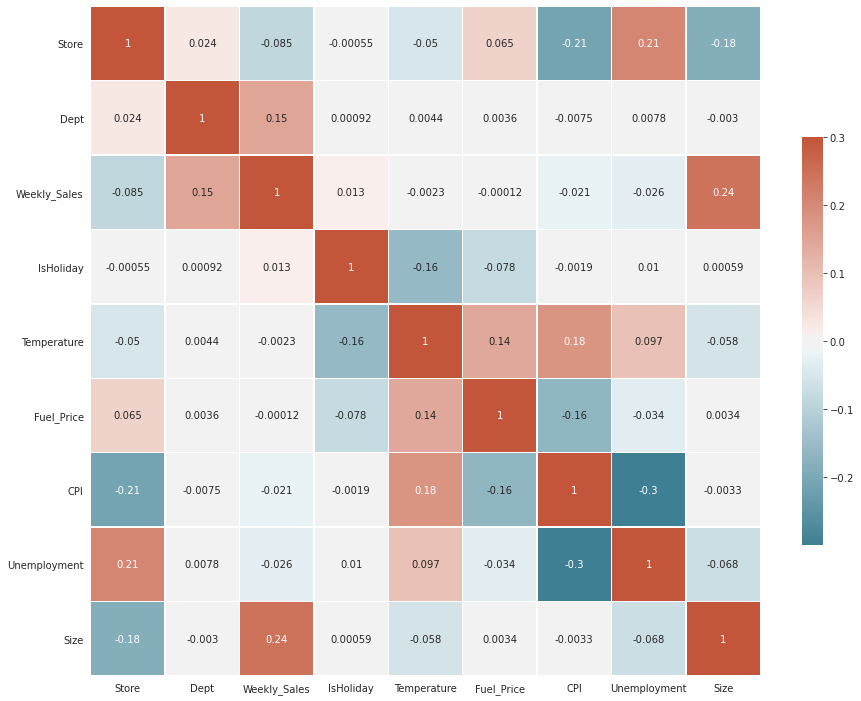

In [15]:
# Plotting the correlation matrix. Here I will check for relations with the Weekly Sales feature
print_correlation_matrix(df_train)

* Dropping features with lower correlation

In [16]:
df_train.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI'], axis=1, inplace=True)

## Checking **Weekly_Sales** behavior

This problem is, by concept, a **Time Series** problem. The sales are directly related to time and our dataset is made in a way that each row corresponds to a different week, store, and dept.

Since this is a time series problem, we can have 3 components that affect the data, besides our original features:

1. **Trend:** are the values growing in time?
1. **Periodic Fluctuations:** do we have some behaviors that happen every month, week, period?
1. **Random or Irregular movements:** some things can not be predicted and they could affect our response. Maybe we had hearthquakes or a flood that could affect our results.

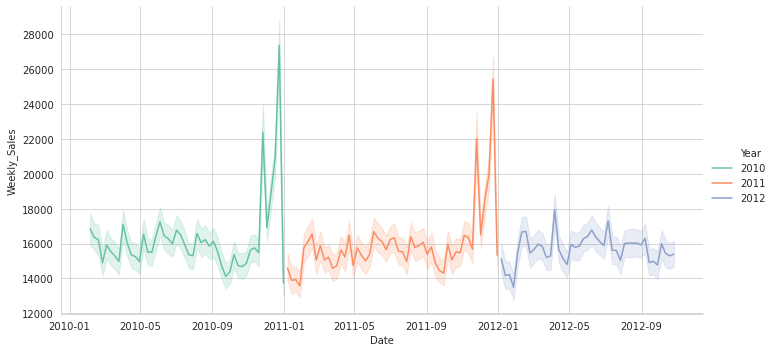

In [17]:
# Here we can see a sazonal behavior on the sales
graph_relation_to_weekly_sale('Year', df_train, x='Date', palette='Set2')

Plotting the average sales on our dataset, we can see:

* **Trend:** no strong evidence of major trend on data
* **Periodic Fluctuations:** strong seasonal behavior. They seem to happen in the same period
* **Random or Irregular movements:** no strong evidence of major random events on data

A strong seasonal behavior makes time extremely important for this problem. So, we will need to create some time-related features to be able to correctly learning those characteristics. Looking at the graph, we can see that the highest sales happens at the end of the year, on **Thanksgiving** and **Christmas** weeks.

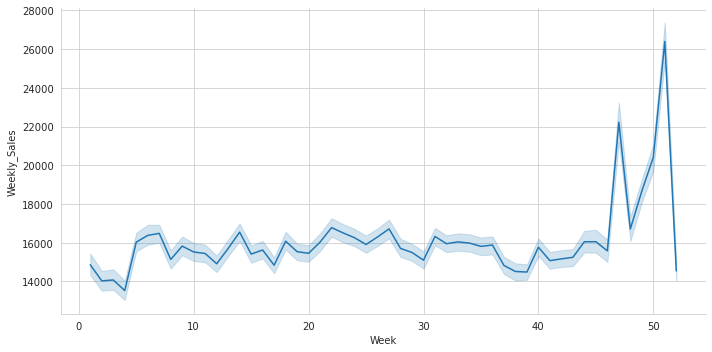

In [18]:
# Week of the year can explain some Weekly_Sales variation
graph_relation_to_weekly_sale(None, df_train, x='Week')

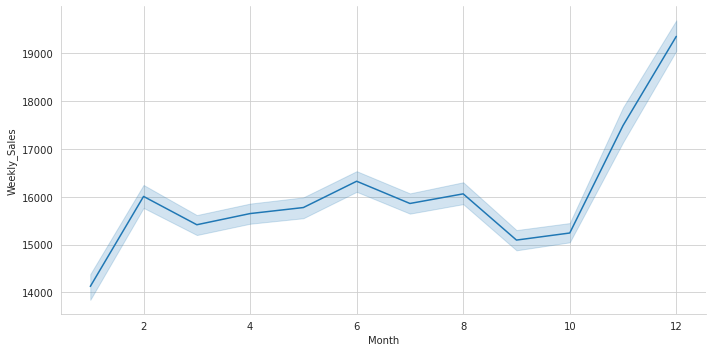

In [19]:
# Month of the year can also explain some Weekly_Sales variation, but not as detailed as the week
graph_relation_to_weekly_sale(None, df_train, x='Month')

The current year can also explain some `Weekly_Sales` variation since the weekly sales seem to  be decreasing with time. However, we need to be careful before jumping to conclusions.
The last year (2012) does not have **Thanksgiving** and **Christmas** days on the training set. The average sales can also be low because of that.

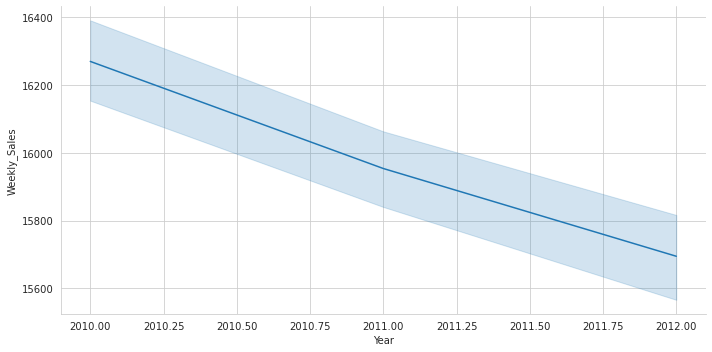

In [20]:
graph_relation_to_weekly_sale(None, df_train, x='Year')

In [21]:
# The year behavior is easier to see in the table below
create_groupped_analysis('Year', df_train)

The number of unique values on the category 'Year' is 3

----------------------------------------
The top 5 'Year' with higher average 'Weekly_Sales':
----------------------------------------


,Weekly_Sales
Year,
2010,16270.275737
2011,15954.070675
2012,15694.948597


## Store Dept, Type, Size vs Weekly_Sales/Holidays

**Type C** seems to have the lowest weekly sales, **Type B** the medium and **Type A** the highest. They are also directly related to the store size.
Holidays have an impact at on Type sales, especially on **Type A** and **Type B**.

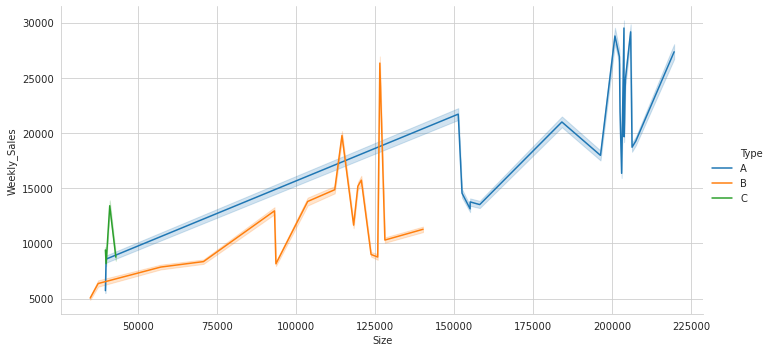

In [22]:
# We can check the correlation between the store and type on the graph below.
graph_relation_to_weekly_sale('Type', df_train, 'Size')

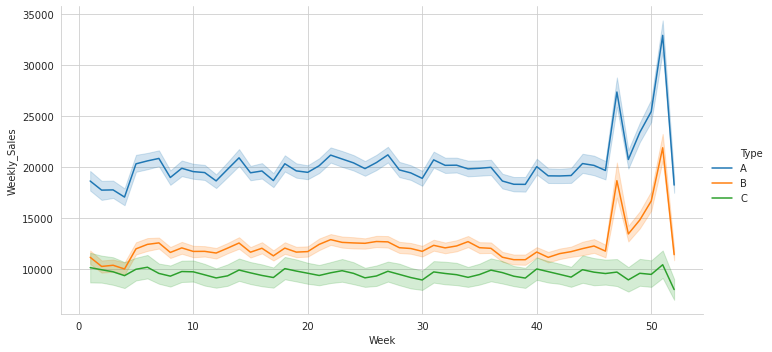

In [23]:
# We can also check this behavior for a year. Store type/store seems to be a multiplier
graph_relation_to_weekly_sale('Type', df_train)

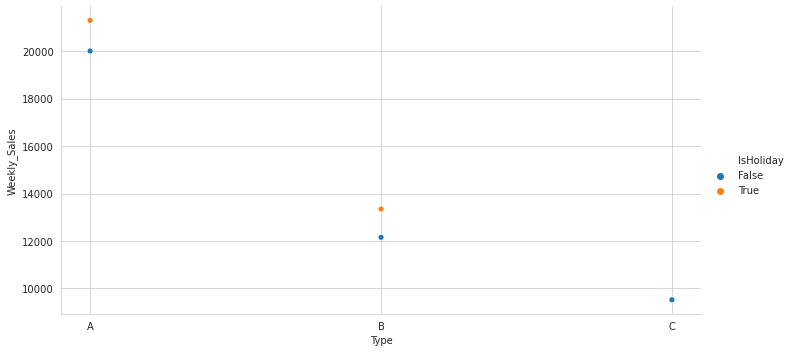

In [24]:
# On the graph below we can see the relation between 'IsHoliday' and 'Type'.
plot_groupped_graph('Type', 'IsHoliday', df_train)

The weekly sales vary depending on the`Dept`. Some `Dept` have higher weekly sales than others and they are affected by the Holidays

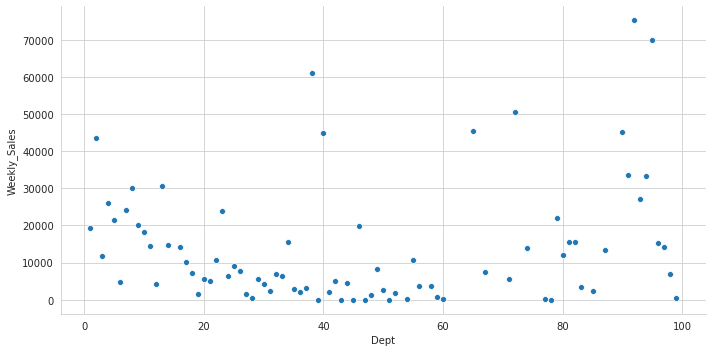

In [25]:
# On the graph below we can see the average weekly sales considering each `Dept`
plot_groupped_graph('Dept', None, df_train)

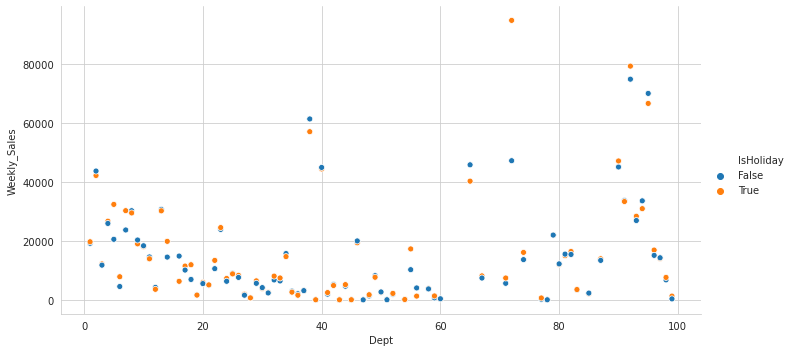

In [26]:
# On the graph below we can see the relation between 'IsHoliday' and 'Dept'
plot_groupped_graph('Dept', 'IsHoliday', df_train)

<div id="feature-engineering"/>
    
# Feature Engineering

After the initial analysis, we found out the necessity of creating some features that could express time and also holiday-related characteristics.

Walmart provided the dates of the four largest holidays:

>For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data): <br>
>**Super Bowl:** 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13<br>
>**Labor Day:** 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13<br>
>**Thanksgiving:** 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13<br>
>**Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13<br>
><br>
>**Reference:** https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

Considering our initial analysis and the nature of the problem, I will create four features:

1. **Week:** week of the year
1. **Month:** month of the year
1. **Year:** observed year
1. **HolidayType:** `[-1 = No Holiday, 0 = Super Bowl, 1 = Labor Day, 2 = Thanksgiving, 3 = Christmas]`

In [27]:
def create_features(df):
    """
    This function creates the following features: Week, Month, Year and
    HolidayType
    """
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1
    
    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])

    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Year'] =  df.Date.dt.year
    df['Month'] =  df.Date.dt.month
    
    # Convert all columns to float
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

In [28]:
create_features(df_train)

<div id="preprocessing"/>

# Preprocessing

One important step in our pipeline is to treat data before our training. On this training dataset, we removed all NaN values but that may not be true considering some predictor unknown data (test dataset). We also make some data transformation to make sure that our model can correctly understand data.

As a programming strategy, we will be using sklearn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) at all steps during our training. This approach makes it easier to have the same transformation at different datasets and to have better control of the entire model pipeline.

**Categorical Features**
1. Fill all missing values with the string `missing` using [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
1. Transform all categorical features into ordinal categories using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Here, we use this transformation for the column `Type`.

**Numerical Features**
1. All numerical data were transformed into `float64` on function **create_features**
1. Fill all missing values to -9999 using [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). We don't have any on the training set, but that can not be true on the test set.  -9999 were chosen because this value is lower than any other value at [Descriptive Analysis](#descriptive-analysis)
1. Standardize features by removing the mean and scaling to unit variance using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [29]:
# Divide dataset for training
X = df_train.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_train['Weekly_Sales']

In [30]:
categorical_features = X.columns[X.dtypes == 'O']
numeric_features = X.columns[X.dtypes == 'float64']

categories = [X[column].unique() for column in X[categorical_features]]
for cat in categories:
    cat[cat == None] = 'missing'

transform_categorical_features = make_pipeline(
    # Fill all NaN values to missing
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    # Transform categorical features into ordinal categories
    OrdinalEncoder(categories=categories)
)

transform_numeric_features = make_pipeline(
    # Fill all NaN values to -1
    SimpleImputer(strategy='constant', fill_value=-9999),
    # Standardize features by removing the mean and scaling to unit variance
    StandardScaler()
)

# Pre-processing transformation
preprocessing_step = make_column_transformer(
    (transform_categorical_features, categorical_features),
    (transform_numeric_features, numeric_features),
    remainder='passthrough'
)

<div id="training"/>

# Training

Training step can be divided into 3 major steps:

1. **[Step 1](#best-ml-model):** Find the best ML model type
1. **[Step 2](#best-hyperparameter):** Find the best hyperparameter combination
1. **[Step 3](#training-full-dataset):** Training the full dataset considering the best model type and hyperparameter combination
---

We avoid overfitting in every step of the training pipeline, I used [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function with a `test_size` of 0.2 since this is a common value used in literature.

In [31]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<div id="best-ml-model"/>

## Step 1: Find the best ML model type

In this section, we used some regression models to find the better one considering **WMAE** evaluation on hyperparameter combination.

The following regression models were tested:
[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), 
[KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), 
[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), 
[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), 
[XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html), 
[RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), and 
[ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

To avoid *overfitting* and have a better view of the models' behavior on different datasets, we used a [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) strategy, considering 3 folds. The better model will be the one with the lowest **WMA**.

In [32]:
regression_models = [
    'LinearRegression',
    'KNN',
    'Ridge',
    'Lasso',
    'XGBRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor'
]

best_model = None
best_error = math.inf

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


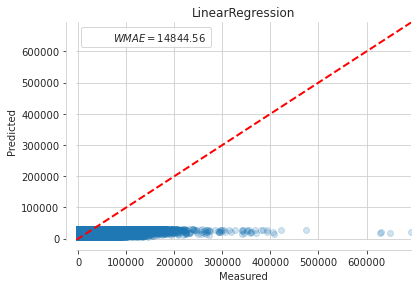

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


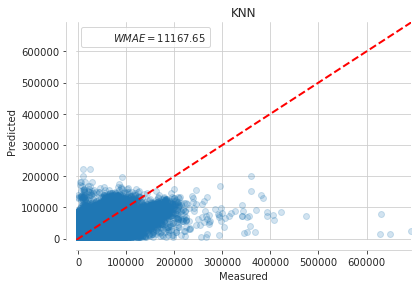

--------------------------------------------------
:: Ridge - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


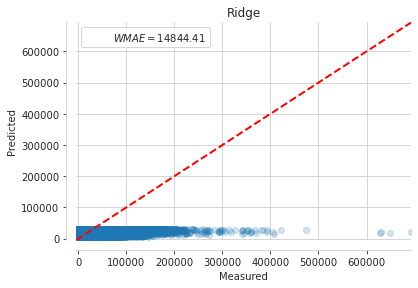

--------------------------------------------------
:: Lasso - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


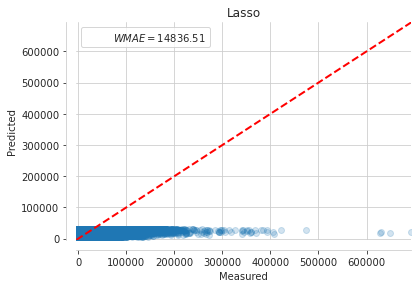

--------------------------------------------------
:: XGBRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.4s finished


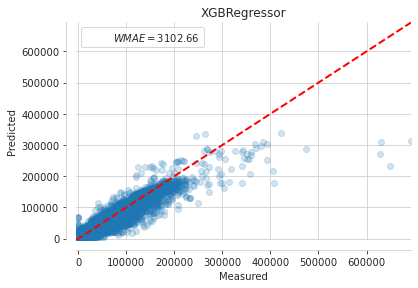

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.5s finished


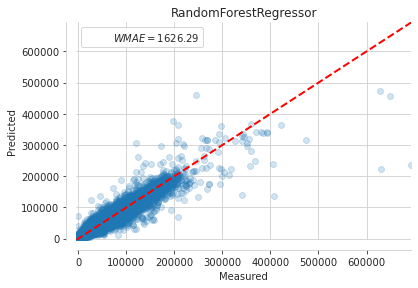

--------------------------------------------------
:: ExtraTreesRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.1s finished


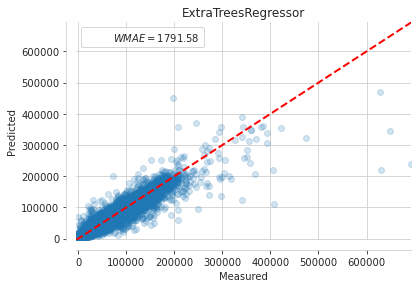

--------------------------------------------------


In [33]:
print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)
    training_pipeline = make_pipeline(
        preprocessing_step,
        regressor
    )

    kfold = KFold(n_splits=3)
    
    y_pred = cross_val_predict(
        training_pipeline,
        X_train,
        y_train,
        cv = kfold,
        n_jobs = -1,
        verbose = 1
    )
    
    wmae_metric = WMAE(X_train, y_train, y_pred)
    
    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name
    
    plot_regression_results(
        y_train,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [34]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 1626.29


<div id="best-hyperparameter"/>

## Step 2: Find the best hyperparameter combination

After finding the best model, we need to find the best combination of hyperparameters. For simplicity's sake, this step was only implemented for the two models with the lowest on [Step 1](#best-ml-model): **ExtraTreesRegressor** and **RandomForestRegressor**.

I'm also using all default model options except for **n_estimators**, since this feature has a huge impact on the final result.
	
> **n_estimators:** The number of trees in the forest.<br>
> **References:**
> [Sklearn - RandomForestRegressor](https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html), 
> [Sklearn - ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

The strategy used here is finding the best hyperparameter combination using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) approach.

In [35]:
# The number of trees in the forest
n_estimators = [x for x in range(50, 250, 50)]

# Create the random grid
random_grid = {
    'model__n_estimators': n_estimators
}

random_grid

{'model__n_estimators': [50, 100, 150, 200]}

In [36]:
def get_best_model_parameters(random_grid, X, y):
    if best_model in ['ExtraTreesRegressor', 'RandomForestRegressor']:
        model = model_factory(best_model)
    else:
        # grid search not implemented for other models
        return {'model__n_estimators': None}

    grid_pipeline =  Pipeline(
        [("preprocessing", preprocessing_step),
         ("model", model)]
    )

    kfold = KFold(n_splits=3)

    model_random = GridSearchCV(
        grid_pipeline,
        param_grid = random_grid,
        cv = kfold,
        verbose = 2,
        n_jobs = -1
    )

    # Create a sample to speed up parameter search
    X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9)
    return model_random.fit(X_sample, y_sample).best_params_

# Best Parameter combination
best_params = get_best_model_parameters(random_grid, X, y)
best_params

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   56.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   56.5s finished


{'model__n_estimators': 100}

<div id="training-full-dataset"/>

## Step 3: Training the full dataset

This step trains a model considering the best model type and hyperparameter combination found on the steps before. Here, I also plotted some graphs and the whole pipeline schema to have a better view of our results and training metrics.

In [37]:
print('-' * 70)
print(f'Best Model: {best_model}: {best_params}\n')
print('Tip: click on the Pipeline diagram below to have a better view of each step.')
print('-' * 70)

model = model_factory(
    best_model,
    n_estimators = best_params['model__n_estimators'],
    verbose = 1,
    n_jobs = -1
)

best_model_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_step),
        ("model", model)
    ]
)

set_config(display='diagram')
best_model_pipeline.fit(X_train, y_train)

----------------------------------------------------------------------
Best Model: RandomForestRegressor: {'model__n_estimators': 100}

Tip: click on the Pipeline diagram below to have a better view of each step.
----------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.9s finished


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values=None,
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['A', 'B', 'C'], dtype=object)]))]),
                                                  Index(['Type'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Store', 'Dept', 'Size', 'Week', 'Month', 'Year', 'HolidayType'], dtype='object'))])),
                ('model', RandomForestRegressor(n_jobs=-1, verbose=1))])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


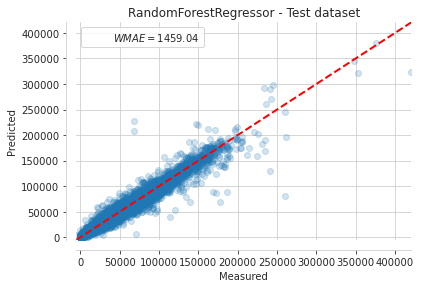

In [38]:
y_pred = best_model_pipeline.predict(X_test)
wmae_metric = WMAE(X_test, y_test, y_pred)

plot_regression_results(
    y_test,
    y_pred,
    f'{best_model} - Test dataset',
    (r'$WMAE ={:.2f}$').format(wmae_metric)
)

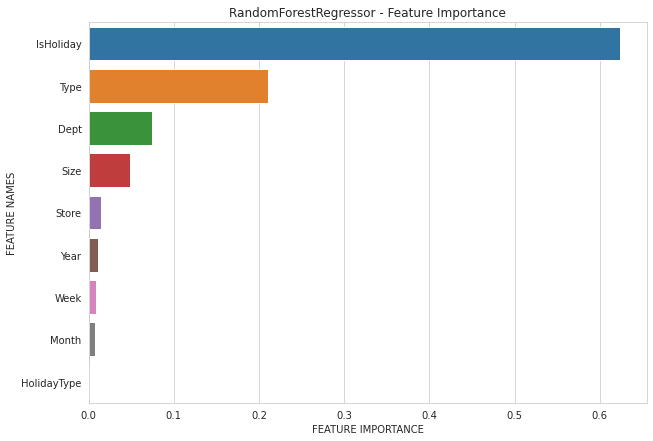

In [39]:
features_importance = best_model_pipeline.steps[1][1].feature_importances_
    
plot_features_importance(
    features_importance,
    X_test.columns,
    best_model
)

<div id="testing"/>

# Testing our Model

After model training, we can apply the resulting model to the test dataset provided by Walmart.

> **test.csv**<br>
> *This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.*<br>
><br>
> **Reference:** https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

On this set, we apply our whole model pipeline on this data (**Preprocessing** + **Model**) using `best_model_pipeline` and plot a graph to see our estimation on the test dataset.

In [40]:
# Creates df_test dataset
df_test = input_dfs['features'].merge(input_dfs['stores'], how='left', on='Store')
df_test = input_dfs['test'].merge(df_test, how='left', on=['Store', 'Date', 'IsHoliday'])
create_features(df_test)
df_test = df_test[list(X_train.columns)]
df_test.head()

,Store,Dept,IsHoliday,Type,Size,Week,Month,Year,HolidayType
0,1.0,1.0,False,A,151315.0,44.0,11.0,2012.0,-1.0
1,1.0,1.0,False,A,151315.0,45.0,11.0,2012.0,-1.0
2,1.0,1.0,False,A,151315.0,46.0,11.0,2012.0,-1.0
3,1.0,1.0,True,A,151315.0,47.0,11.0,2012.0,2.0
4,1.0,1.0,False,A,151315.0,48.0,11.0,2012.0,-1.0


In [41]:
y_pred = best_model_pipeline.predict(df_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


* We can see, on the graph below, that our prediction was able to get data sazonal component of this problem

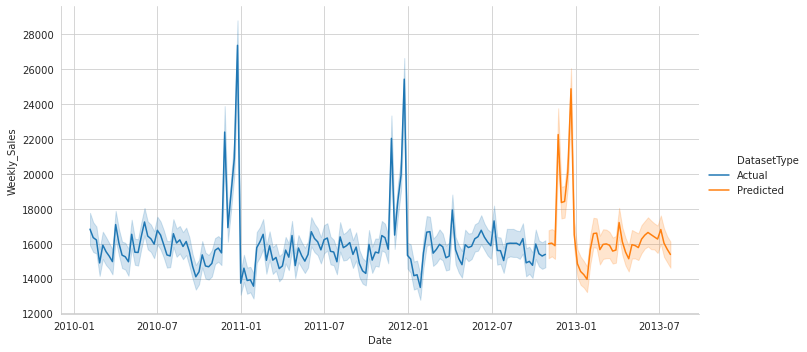

In [42]:
df_test['Weekly_Sales'] = y_pred
df_test['DatasetType'] = 'Predicted'
df_test['Date'] = input_dfs['test']['Date'].values # we dropped this column earlier

df_train['DatasetType'] = 'Actual'
df_train['Date'] = input_dfs['train']['Date'].values # we dropped this column earlier

df_result = df_train.append(df_test)

graph_relation_to_weekly_sale('DatasetType', df_result, x='Date')

<div id="submission"/>

# Make submission

After predicting the test dataset, we can submit our results to Kaggle evaluation and check our final score.

In [43]:
input_dfs['sampleSubmission']['Weekly_Sales'] = y_pred
input_dfs['sampleSubmission'].to_csv('submission.csv',index=False)
input_dfs['sampleSubmission']

,Id,Weekly_Sales
0,1_1_2012-11-02,34842.1089
1,1_1_2012-11-09,19196.6979
2,1_1_2012-11-16,19699.5150
3,1_1_2012-11-23,20363.4131
4,1_1_2012-11-30,21314.6570
5,1_1_2012-12-07,33780.2906
6,1_1_2012-12-14,47903.8094
7,1_1_2012-12-21,47794.8555
8,1_1_2012-12-28,22968.2762
9,1_1_2013-01-04,16825.5963


<div id="next-steps"/>

# Next steps

1. Work with time series decomposition methods, to get a better view of seasonal components and get other important data markdowns besides the four holidays that Walmart provided;
1. The created custom features, besides time-related ones, don't seem to contribute to this model. When we look at the Feature Importance, `HolidayType` didn't have a great contribution. Maybe this is happening because this feature and the feature `Week` kind of explain the same thing. A further investigation in this matter would be a nice next step;
1. Try new models and hyperparameters combinations.